In [4]:
# Core
import os
import numpy as np
import pandas as pd

# Data
import yfinance as yf

# Plots
import matplotlib.pyplot as plt

# ML
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Deep learning
import tensorflow as tf
from tensorflow.keras import layers, callbacks, Model

print("tf:", tf.__version__)
print("pandas:", pd.__version__)
print("yfinance:", yf.__version__)

tf: 2.16.1
pandas: 2.2.1
yfinance: 0.2.37


In [5]:

from pathlib import Path

TICKER = "AAPL"
START  = "2015-01-01"  # we will restrict the frame to >= this date
END    = None
DATA_CACHE = Path(f"{TICKER}_daily.csv")

def _clean_ohlcv(df: pd.DataFrame) -> pd.DataFrame:
    df = df.rename(columns=str.lower)
    need = ['open','high','low','close','volume']
    df = df[[c for c in need if c in df.columns]]
    for c in need:
        df[c] = pd.to_numeric(df.get(c), errors='coerce')
    df = df.dropna().sort_index()
    df.index = pd.to_datetime(df.index, utc=False)
    df.index.name = "Date"
    return df

def fetch_from_yahoo(ticker=TICKER, start=START, end=END) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end, interval="1d",
                     auto_adjust=True, progress=False, threads=True)
    if df is None or df.empty:
        raise RuntimeError("Yahoo returned empty")
    df = _clean_ohlcv(df)
    if df.empty:
        raise RuntimeError("Yahoo cleaned frame empty")
    return df

def fetch_from_stooq(ticker=TICKER) -> pd.DataFrame:
    # Try both base and .US variants
    candidates = [ticker.lower(), f"{ticker.lower()}.us"]
    last_err = None
    for sym in candidates:
        try:
            url = f"https://stooq.com/q/d/l/?s={sym}&i=d"
            df = pd.read_csv(url)
            if 'Date' not in df.columns:
                raise RuntimeError("No Date column from Stooq")
            df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
            df = df.set_index('Date').sort_index()
            df = df.rename(columns={'Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'})
            df = _clean_ohlcv(df)
            if not df.empty:
                return df
        except Exception as e:
            last_err = e
            continue
    raise RuntimeError(f"Stooq failed for {ticker}: {last_err}")

def load_or_fetch_cache(path: Path) -> pd.DataFrame:
    def _write(df: pd.DataFrame):
        df.index.name = "Date"
        df.to_csv(path, index=True)

    # Try to read existing cache
    if path.exists():
        try:
            raw = pd.read_csv(path, parse_dates=['Date'], index_col='Date')
            raw = _clean_ohlcv(raw)
            if raw.empty:
                raise RuntimeError("Cached CSV cleaned to empty")
            return raw
        except Exception:
            # Bad/partial cache → delete and refetch
            path.unlink(missing_ok=True)

    # Fetch fresh (Yahoo → Stooq)
    try:
        raw = fetch_from_yahoo()
        # raw.index.name = "Date"
        # raw.to_csv(DATA_CACHE, index=True)
    except Exception:
        raw = fetch_from_stooq()
    _write(raw)
    return raw

# ---- Run loader
raw_full = load_or_fetch_cache(DATA_CACHE)
print("Loaded:", raw_full.index.min(), "→", raw_full.index.max(), raw_full.shape)
print(raw_full.dtypes)


Loaded: 1984-09-07 00:00:00 → 2025-08-26 00:00:00 (10322, 5)
open      float64
high      float64
low       float64
close     float64
volume      int64
dtype: object


Range (analysis): 2015-01-02 00:00:00 → 2025-08-26 00:00:00 | rows: 2678


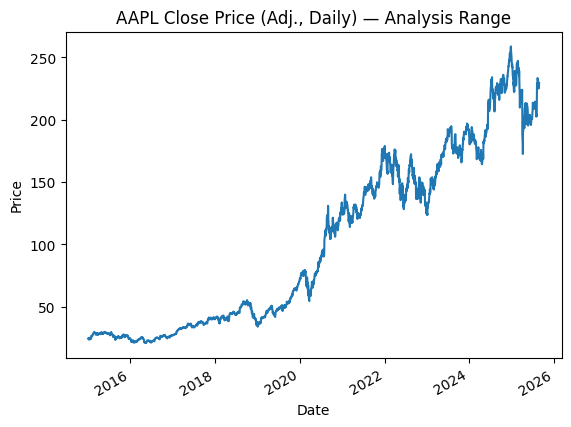

In [6]:

# Restrict to analysis window
raw = raw_full.loc[START or "2015-01-01":].copy()

print("Range (analysis):", raw.index.min(), "→", raw.index.max(), "| rows:", len(raw))
assert {'open','high','low','close','volume'}.issubset(raw.columns)
assert raw.index.dtype.kind == 'M'

ax = raw['close'].plot(title=f"{TICKER} Close Price (Adj., Daily) — Analysis Range")
ax.set_xlabel("Date"); ax.set_ylabel("Price"); plt.show()


In [7]:
def date_split(df, train_end="2022-12-30", val_end="2023-12-29"):
    df = df.sort_index()
    train = df.loc[:train_end]
    val   = df.loc[pd.to_datetime(train_end) + pd.Timedelta(days=1): val_end]
    test  = df.loc[pd.to_datetime(val_end)   + pd.Timedelta(days=1): ]
    return train, val, test

def metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# Perform split
train, val, test = date_split(raw[['close','volume']])
print("Train:", train.index.min(), "→", train.index.max(), len(train))
print("Val:  ", val.index.min(),   "→", val.index.max(),   len(val))
print("Test: ", test.index.min(),  "→", test.index.max(),  len(test))

Train: 2015-01-02 00:00:00 → 2022-12-30 00:00:00 2014
Val:   2023-01-03 00:00:00 → 2023-12-29 00:00:00 250
Test:  2024-01-02 00:00:00 → 2025-08-26 00:00:00 414


Naive baseline (val) - MAE/RMSE/MAPE: 1.635273092369476 2.1176015160371615 0.97%


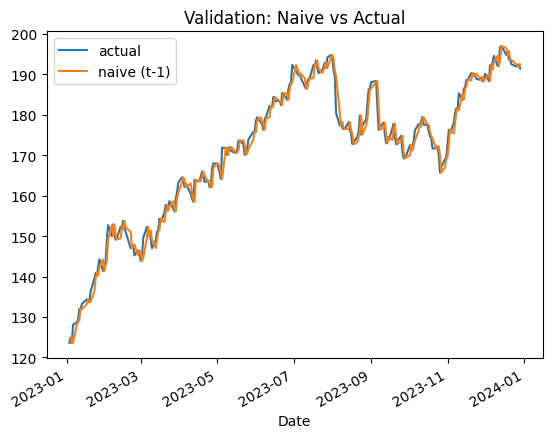

In [8]:
# Naive: today's close = yesterday's close
def naive_forecast(series):
    return series.shift(1)

y_true_val = val['close']
y_pred_val_naive = naive_forecast(val['close']).dropna()
mae, rmse, mape = metrics(y_true_val.loc[y_pred_val_naive.index], y_pred_val_naive)
print("Naive baseline (val) - MAE/RMSE/MAPE:", mae, rmse, f"{mape:.2f}%")

ax = y_true_val.plot(label="actual", title="Validation: Naive vs Actual")
y_pred_val_naive.plot(ax=ax, label="naive (t-1)")
plt.legend(); plt.show()

Linear (val) - MAE/RMSE/MAPE: 1.6712814003995522 2.1703287838960006 0.99%


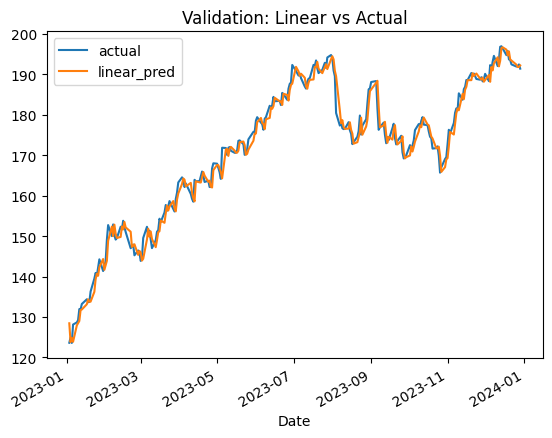

In [9]:

def make_lag_features(df, target_col='close', lags=(1,2,3,5,10), roll_windows=(5,10,20)):
    X = pd.DataFrame(index=df.index)
    # Lags
    for L in lags:
        X[f'close_lag_{L}'] = df[target_col].shift(L)
    # Rolling means/stds (use shift(1) to avoid peeking)
    for w in roll_windows:
        X[f'roll_mean_{w}'] = df[target_col].shift(1).rolling(w).mean()
        X[f'roll_std_{w}']  = df[target_col].shift(1).rolling(w).std()
    # Volume lag
    X['volume_lag_1'] = df['volume'].shift(1)
    y = df[target_col]
    return X, y

def dropna_align(X, y):
    valid = X.dropna().index.intersection(y.dropna().index)
    return X.loc[valid], y.loc[valid]

X_all, y_all = make_lag_features(raw[['close','volume']])
X_train, y_train = X_all.loc[train.index], y_all.loc[train.index]
X_val,   y_val   = X_all.loc[val.index],   y_all.loc[val.index]
X_test,  y_test  = X_all.loc[test.index],  y_all.loc[test.index]

X_train, y_train = dropna_align(X_train, y_train)
X_val,   y_val   = dropna_align(X_val, y_val)
X_test,  y_test  = dropna_align(X_test, y_test)

linear_regression = LinearRegression().fit(X_train, y_train)

val_pred_lin = pd.Series(linear_regression.predict(X_val), index=X_val.index).loc[y_val.index]
mae, rmse, mape = metrics(y_val, val_pred_lin)
print("Linear (val) - MAE/RMSE/MAPE:", mae, rmse, f"{mape:.2f}%")

ax = y_val.plot(label="actual", title="Validation: Linear vs Actual")
val_pred_lin.plot(ax=ax, label="linear_pred")
plt.legend()
plt.show()

Seq shapes: (1954, 60, 2) (250, 60, 2) (414, 60, 2)
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0027 - val_loss: 0.0187 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0096 - val_loss: 0.0080 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0040 - val_loss: 0.0057 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.5113e-04 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.2789e-04 - val_loss: 0.0094 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0018 - 

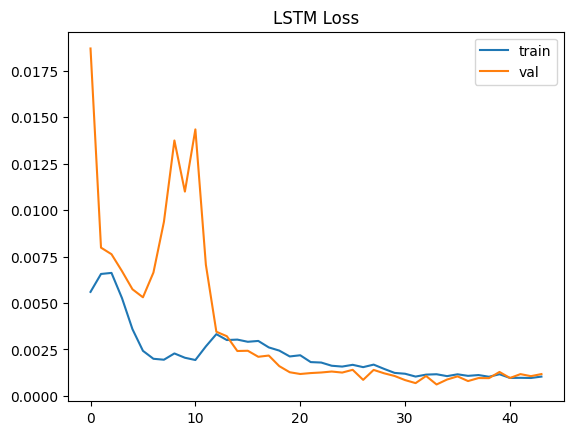

In [10]:
LOOKBACK = 60

# Fit scaler on TRAIN only (no leakage)
scaler = MinMaxScaler().fit(train[['close','volume']])

# Transform entire analysis window with train-fitted scaler
scaled = pd.DataFrame(
    scaler.transform(raw[['close','volume']]),
    index=raw.index, columns=['close','volume']
)

def make_sequences(df_scaled, lookback=LOOKBACK, target_col='close'):
    X_list, y_list, idx_list = [], [], []
    arr = df_scaled.values
    t_idx = df_scaled.index
    t_col = df_scaled.columns.get_loc(target_col)
    for i in range(lookback, len(df_scaled)):
        X_list.append(arr[i-lookback:i, :])
        y_list.append(arr[i, t_col])
        idx_list.append(t_idx[i])
    return np.array(X_list), np.array(y_list), pd.Index(idx_list)

X_all_seq, y_all_seq, idx_seq = make_sequences(scaled)

# Masks by calendar ranges
train_mask = (idx_seq >= train.index.min()) & (idx_seq <= train.index.max())
val_mask   = (idx_seq >= val.index.min())   & (idx_seq <= val.index.max())
test_mask  = (idx_seq >= test.index.min())  & (idx_seq <= test.index.max())

X_seq_train, y_seq_train = X_all_seq[train_mask], y_all_seq[train_mask]
X_seq_val,   y_seq_val   = X_all_seq[val_mask],   y_all_seq[val_mask]
X_seq_test,  y_seq_test  = X_all_seq[test_mask],  y_all_seq[test_mask]

print("Seq shapes:", X_seq_train.shape, X_seq_val.shape, X_seq_test.shape)

tf.keras.backend.clear_session()

inp = layers.Input(shape=(LOOKBACK, X_seq_train.shape[-1]))
x   = layers.LSTM(64, return_sequences=False)(inp)
x   = layers.Dropout(0.2)(x)
out = layers.Dense(1)(x)  # predict scaled close

model = Model(inp, out)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss='mse')

es  = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

hist = model.fit(
    X_seq_train, y_seq_train,
    validation_data=(X_seq_val, y_seq_val),
    epochs=100, batch_size=32, shuffle=False,
    callbacks=[es, rlr], verbose=1
)

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.legend(); plt.title("LSTM Loss"); plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
LSTM (val) - MAE/RMSE/MAPE: 3.2649177200671526 3.903523314289075 1.88%


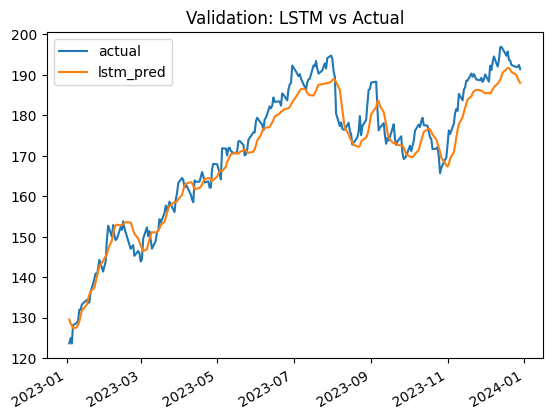

In [11]:
def inverse_close(scaled_close_values):
    # Build a 2-col dummy, because scaler expects both columns
    dummy = np.zeros((len(scaled_close_values), 2))
    dummy[:, 0] = scaled_close_values  # close is column 0
    inv = scaler.inverse_transform(dummy)[:, 0]
    return inv

# Validation evaluation
val_pred_scaled = model.predict(X_seq_val).ravel()
val_pred        = inverse_close(val_pred_scaled)

val_idx_for_seq = idx_seq[val_mask]
y_val_true      = raw.loc[val_idx_for_seq, 'close'].values

mae, rmse, mape = metrics(y_val_true, val_pred)
print("LSTM (val) - MAE/RMSE/MAPE:", mae, rmse, f"{mape:.2f}%")

actual_series = pd.Series(np.ravel(y_val_true), index=val_idx_for_seq)
pred_series   = pd.Series(np.ravel(val_pred),   index=val_idx_for_seq)
ax = actual_series.plot(label="actual", title="Validation: LSTM vs Actual")
pred_series.plot(ax=ax, label="lstm_pred")
plt.legend()
plt.show()

In [12]:
# Linear on test
test_pred_lin = pd.Series(linear_regression.predict(X_test), index=X_test.index).loc[y_test.index]
lin_mae, lin_rmse, lin_mape = metrics(y_test, test_pred_lin)

# LSTM on test
test_pred_scaled = model.predict(X_seq_test).ravel()
test_pred        = inverse_close(test_pred_scaled)
test_idx_for_seq = idx_seq[test_mask]
y_test_true      = raw.loc[test_idx_for_seq, 'close'].values
lstm_mae, lstm_rmse, lstm_mape = metrics(y_test_true, test_pred)

# Naive on test
naive_test = naive_forecast(raw.loc[test.index, 'close']).dropna()
naive_mae, naive_rmse, naive_mape = metrics(
    raw.loc[naive_test.index, 'close'], naive_test
)

summary = pd.DataFrame({
    'Model': ['Naive (t-1)', 'Linear (lags)', 'LSTM'],
    'MAE':   [naive_mae, lin_mae, lstm_mae],
    'RMSE':  [naive_rmse, lin_rmse, lstm_rmse],
    'MAPE%': [naive_mape, lin_mape, lstm_mape]
}).sort_values('RMSE')

print(summary)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
           Model       MAE       RMSE     MAPE%
0    Naive (t-1)  2.524906   3.751455  1.209540
1  Linear (lags)  2.587922   3.793829  1.240405
2           LSTM  9.463766  11.300938  4.309298


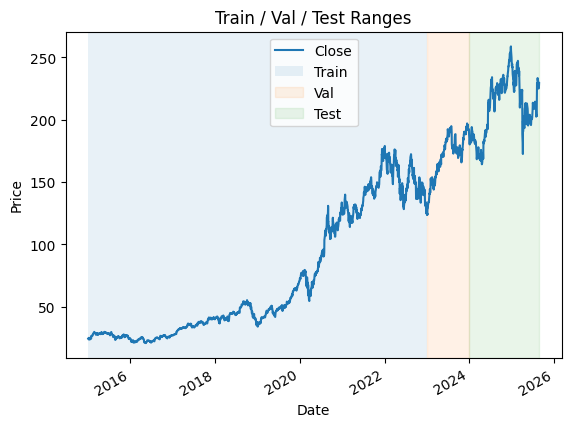

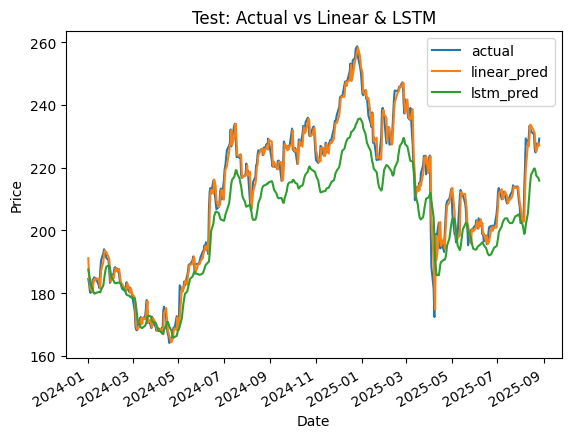

In [13]:
# Plot bands for splits
fig, ax = plt.subplots()
raw['close'].plot(ax=ax, label='Close')
ax.axvspan(train.index.min(), train.index.max(), alpha=0.1, label='Train')
ax.axvspan(val.index.min(), val.index.max(),   alpha=0.1, label='Val', color='tab:orange')
ax.axvspan(test.index.min(), test.index.max(), alpha=0.1, label='Test', color='tab:green')
ax.set_title("Train / Val / Test Ranges")
ax.set_xlabel("Date"); ax.set_ylabel("Price")
ax.legend(); plt.show()

# Test: actual vs predictions (Linear vs LSTM)
test_actual_series = raw.loc[test_idx_for_seq, 'close']
test_lin_series = test_pred_lin.reindex(test_actual_series.index, method='nearest')  # align to dates
test_lstm_series = pd.Series(np.ravel(test_pred), index=test_idx_for_seq)

fig, ax = plt.subplots()
test_actual_series.plot(ax=ax, label="actual")
test_lin_series.plot(ax=ax, label="linear_pred")
test_lstm_series.plot(ax=ax, label="lstm_pred")
ax.set_title("Test: Actual vs Linear & LSTM")
ax.set_xlabel("Date"); ax.set_ylabel("Price")
ax.legend(); plt.show()

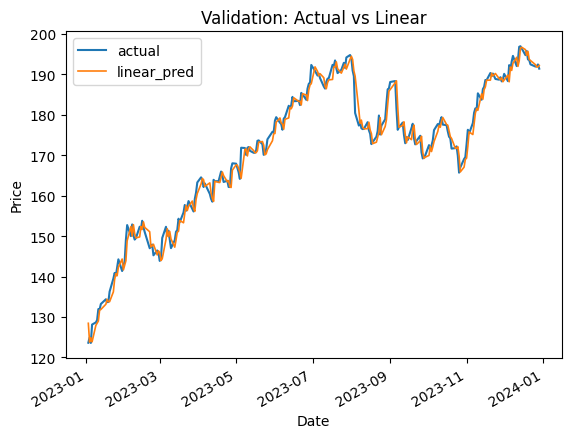

In [14]:
fig, ax = plt.subplots()
y_val.plot(ax=ax, label="actual", linewidth=1.5)
val_pred_lin.reindex(y_val.index).plot(ax=ax, label="linear_pred", linewidth=1.2)
ax.set_title("Validation: Actual vs Linear"); ax.set_xlabel("Date"); ax.set_ylabel("Price")
ax.legend(); plt.show()

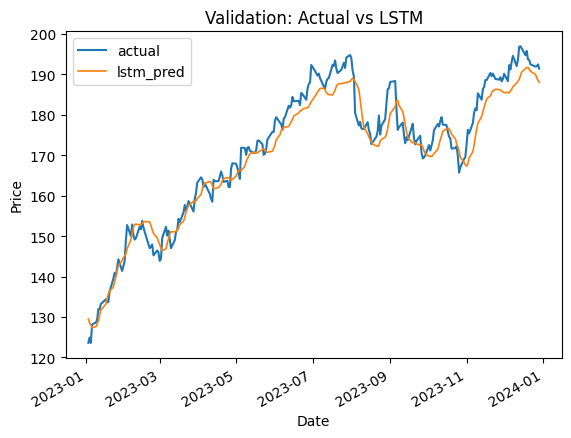

In [15]:
actual_val = pd.Series(y_val_true, index=val_idx_for_seq)
lstm_val   = pd.Series(val_pred,   index=val_idx_for_seq)

fig, ax = plt.subplots()
actual_val.plot(ax=ax, label="actual", linewidth=1.5)
lstm_val.plot(ax=ax,   label="lstm_pred", linewidth=1.2)
ax.set_title("Validation: Actual vs LSTM"); ax.set_xlabel("Date"); ax.set_ylabel("Price")
ax.legend(); plt.show()

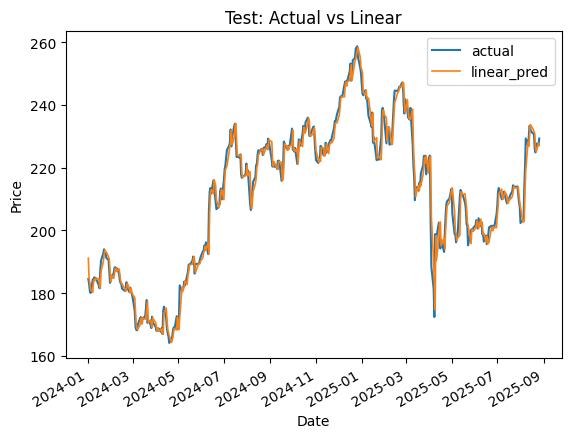

In [16]:
# y_test and test_pred_lin were aligned via dropna_align; keep that index for plotting
fig, ax = plt.subplots()
y_test.plot(ax=ax, label="actual", linewidth=1.5)
test_pred_lin.reindex(y_test.index).plot(ax=ax, label="linear_pred", linewidth=1.2)
ax.set_title("Test: Actual vs Linear"); ax.set_xlabel("Date"); ax.set_ylabel("Price")
ax.legend(); plt.show()

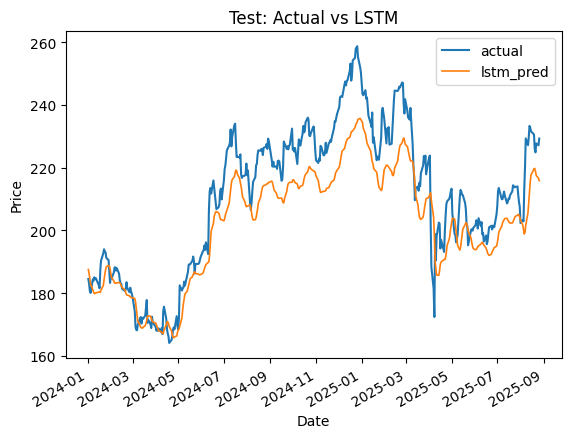

In [17]:
actual_test = raw.loc[test_idx_for_seq, 'close']
lstm_test   = pd.Series(test_pred, index=test_idx_for_seq)

fig, ax = plt.subplots()
actual_test.plot(ax=ax, label="actual", linewidth=1.5)
lstm_test.plot(ax=ax,   label="lstm_pred", linewidth=1.2)
ax.set_title("Test: Actual vs LSTM"); ax.set_xlabel("Date"); ax.set_ylabel("Price")
ax.legend(); plt.show()

In [18]:
# Linear
mae, rmse, mape = metrics(y_val, val_pred_lin)
print("Linear (val):", mae, rmse, f"{mape:.2f}%")

# LSTM
mae, rmse, mape = metrics(y_val_true, val_pred)  # arrays already aligned
print("LSTM (val):", mae, rmse, f"{mape:.2f}%")

# Naive
y_pred_val_naive = naive_forecast(val['close']).dropna()
mae, rmse, mape = metrics(val['close'].loc[y_pred_val_naive.index], y_pred_val_naive)
print("Naive (val):", mae, rmse, f"{mape:.2f}%")


print("\n")
# Linear
lin_mae, lin_rmse, lin_mape = metrics(y_test, test_pred_lin)

# LSTM
lstm_mae, lstm_rmse, lstm_mape = metrics(y_test_true, test_pred)

# Naive
naive_test = naive_forecast(test['close']).dropna()
naive_mae, naive_rmse, naive_mape = metrics(test['close'].loc[naive_test.index], naive_test)

print("Linear (test):", lin_mae, lin_rmse, f"{lin_mape:.2f}%")
print("LSTM (test):", lstm_mae, lstm_rmse, f"{lstm_mape:.2f}%")
print("Naive (test):", naive_mae, naive_rmse, f"{naive_mape:.2f}%")


print("\n")


summary = pd.DataFrame({
    'Model': ['Naive (t-1)', 'Linear (lags)', 'LSTM'],
    'MAE':   [naive_mae, lin_mae, lstm_mae],
    'RMSE':  [naive_rmse, lin_rmse, lstm_rmse],
    'MAPE%': [naive_mape, lin_mape, lstm_mape]
}).sort_values('RMSE')

print(summary)

Linear (val): 1.6712814003995522 2.1703287838960006 0.99%
LSTM (val): 3.2649177200671526 3.903523314289075 1.88%
Naive (val): 1.635273092369476 2.1176015160371615 0.97%


Linear (test): 2.58792241349404 3.7938288162181166 1.24%
LSTM (test): 9.463765596538947 11.3009376465556 4.31%
Naive (test): 2.524905569007264 3.751454697024298 1.21%


           Model       MAE       RMSE     MAPE%
0    Naive (t-1)  2.524906   3.751455  1.209540
1  Linear (lags)  2.587922   3.793829  1.240405
2           LSTM  9.463766  11.300938  4.309298


Latest available date in dataset: 2025-08-26 00:00:00

Next 5 business-day predictions:
            Linear_Pred_Close  LSTM_Pred_Close
Date                                          
2025-08-27             228.96           215.68
2025-08-28             228.75           213.72
2025-08-29             228.59           211.30
2025-09-02             228.44           208.71
2025-09-03             228.30           206.06


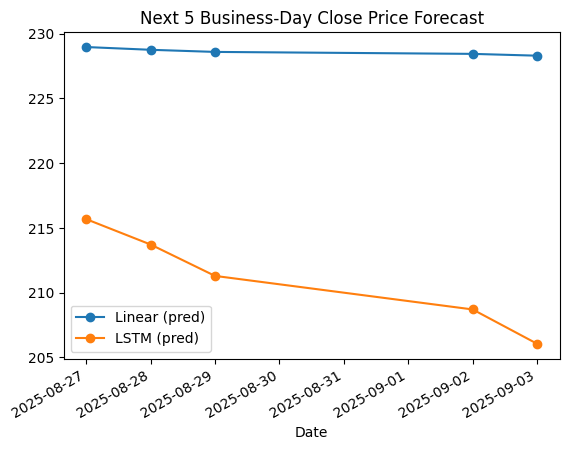

In [19]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# ===============================
# Predict Next 5 Business Days (US holidays aware)
# ===============================

print("Latest available date in dataset:", raw.index.max())

# Business-day frequency that skips weekends + US federal holidays
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

# Generate the next 5 trading dates
future_dates = pd.date_range(start=raw.index.max() + us_bd, periods=5, freq=us_bd)

# --- Prepare copies we can extend during recursive forecasting ---
# For Linear Regression: needs lag/rolling features based on close (and volume_lag_1)
work_df = raw[['close', 'volume']].copy()
last_known_volume = float(work_df['volume'].iloc[-1])

# For LSTM: needs the last LOOKBACK scaled window; keep last scaled volume for future rows
last_scaled_vol = float(scaled['volume'].iloc[-1])
window_scaled = scaled.iloc[-LOOKBACK:].copy()  # shape: (LOOKBACK, 2)

lin_preds = []
lstm_preds = []

for d in future_dates:
    # ----------------------
    # Linear Regression step
    # ----------------------
    # Append placeholder row with last known volume (so volume_lag_1 can form)
    work_df.loc[d, 'volume'] = last_known_volume
    # Build features on the extended frame and grab last row
    X_all, _ = make_lag_features(work_df)
    X_last = X_all.iloc[[-1]]
    # Predict close and write it back so subsequent lags/rolls can use it
    lin_close = float(linear_regression.predict(X_last)[0])
    work_df.loc[d, 'close'] = lin_close
    lin_preds.append(lin_close)

    # -------------
    # LSTM step
    # -------------
    # Predict next close (scaled) from the last LOOKBACK window
    last_window = window_scaled.values.reshape(1, LOOKBACK, -1)  # (1, LOOKBACK, 2)
    next_close_scaled = float(model.predict(last_window, verbose=0).ravel()[0])
    # Inverse-scale the close for reporting
    next_close = float(inverse_close([next_close_scaled])[0])
    lstm_preds.append(next_close)
    # Append the new scaled row for the next iteration
    new_row_scaled = pd.DataFrame([[next_close_scaled, last_scaled_vol]],
                                  index=[d], columns=['close', 'volume'])
    window_scaled = pd.concat([window_scaled, new_row_scaled]).iloc[-LOOKBACK:]

# --- Collate results ---
future_pred = pd.DataFrame({
    'Date': future_dates,
    'Linear_Pred_Close': lin_preds,
    'LSTM_Pred_Close': lstm_preds,
}).set_index('Date')

print("\nNext 5 business-day predictions:")
print(future_pred.round(2))

# Optional: quick plot
ax = future_pred['Linear_Pred_Close'].plot(marker='o', label='Linear (pred)', title='Next 5 Business-Day Close Price Forecast')
future_pred['LSTM_Pred_Close'].plot(ax=ax, marker='o', label='LSTM (pred)')
plt.legend()
plt.show()

In [28]:
from datetime import date

# Save next 5 trading day predictions (Linear Regression + LSTM) to text file
output_file = "next_5_day_predictions.txt"

with open(output_file, "w") as f:
    f.write(f"Todays date: {date.today()}\n\n")
    f.write("Next 5 Business-Day Predictions\n")
    f.write("="*40 + "\n\n")
    for date, row in future_pred.iterrows():
        f.write(f"Date: {date.strftime('%Y-%m-%d')}\n")
        f.write(f"  Linear Regression Close Price Prediction: {row['Linear_Pred_Close']:.2f}\n")
        f.write(f"  LSTM Close Price Prediction: {row['LSTM_Pred_Close']:.2f}\n\n")
    f.close()
print(f"Predictions saved to {output_file}")

Predictions saved to next_5_day_predictions.txt


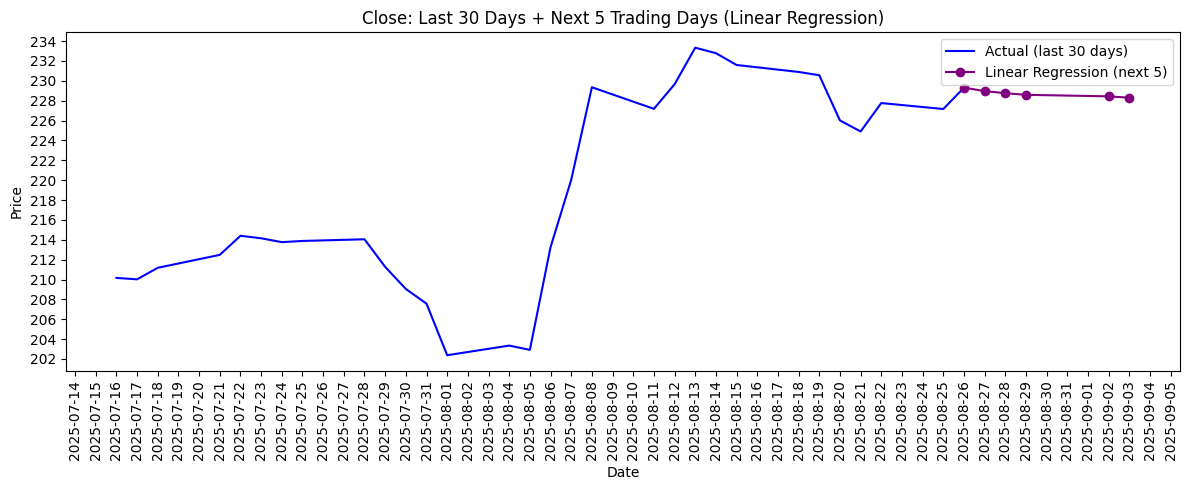

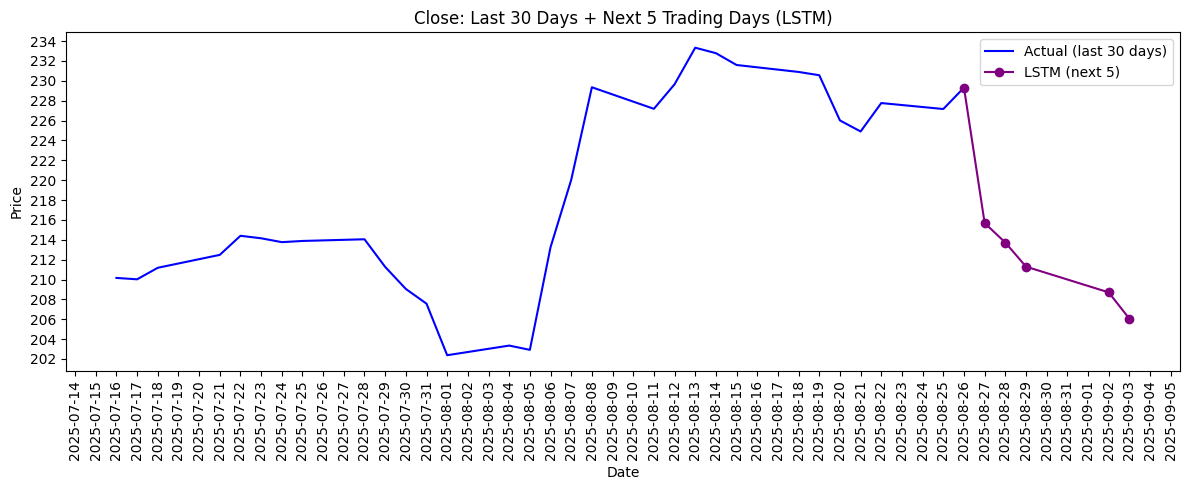

In [21]:
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator

# =========================
# Plot 1: Last 30 actual + next 5 (Linear Regression, connected line, all dates)
# =========================
past_30 = raw['close'].iloc[-30:]
plt.figure(figsize=(12, 5))

# Actual history
plt.plot(past_30.index, past_30.values, label='Actual (last 30 days)', color="blue")

# Forecast connected to last actual close
lin_x = [past_30.index[-1]] + list(future_pred.index)
lin_y = [past_30.values[-1]] + list(future_pred['Linear_Pred_Close'].values)
plt.plot(lin_x, lin_y, marker='o', label='Linear Regression (next 5)', color='purple')

# Show every trading day on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)
ax.yaxis.set_major_locator(MultipleLocator(2))

plt.title('Close: Last 30 Days + Next 5 Trading Days (Linear Regression)')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(); plt.tight_layout()
plt.show()

# =========================
# Plot 2: Last 30 actual + next 5 (LSTM, connected line, all dates)
# =========================
plt.figure(figsize=(12, 5))

# Actual history
plt.plot(past_30.index, past_30.values, label='Actual (last 30 days)', color="blue")

# Forecast connected to last actual close
lstm_x = [past_30.index[-1]] + list(future_pred.index)
lstm_y = [past_30.values[-1]] + list(future_pred['LSTM_Pred_Close'].values)
plt.plot(lstm_x, lstm_y, marker='o', label='LSTM (next 5)', color='purple')

# Show every trading day on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)
ax.yaxis.set_major_locator(MultipleLocator(2))

plt.title('Close: Last 30 Days + Next 5 Trading Days (LSTM)')
plt.xlabel('Date'); plt.ylabel('Price')
plt.legend(); plt.tight_layout()
plt.show()

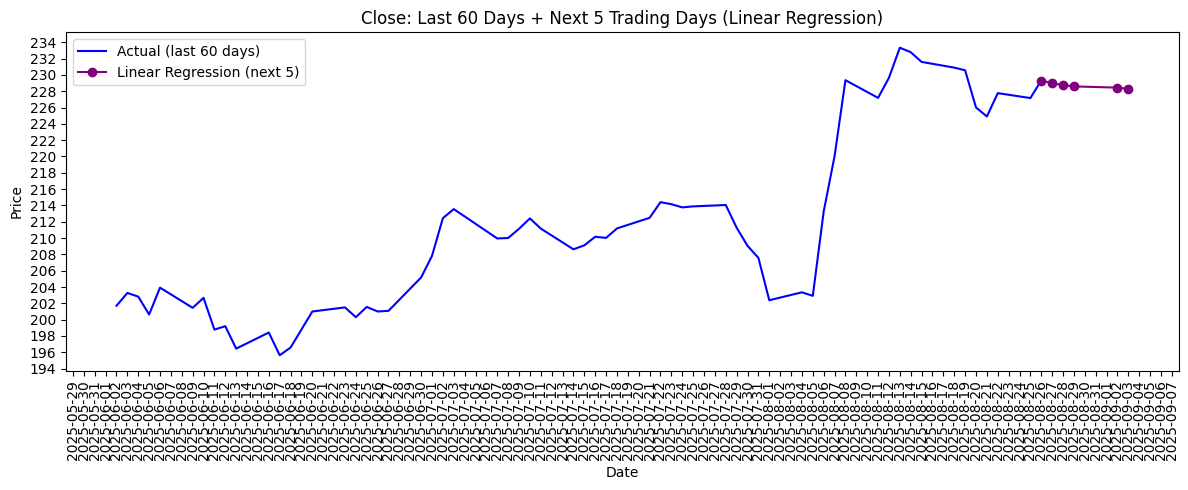

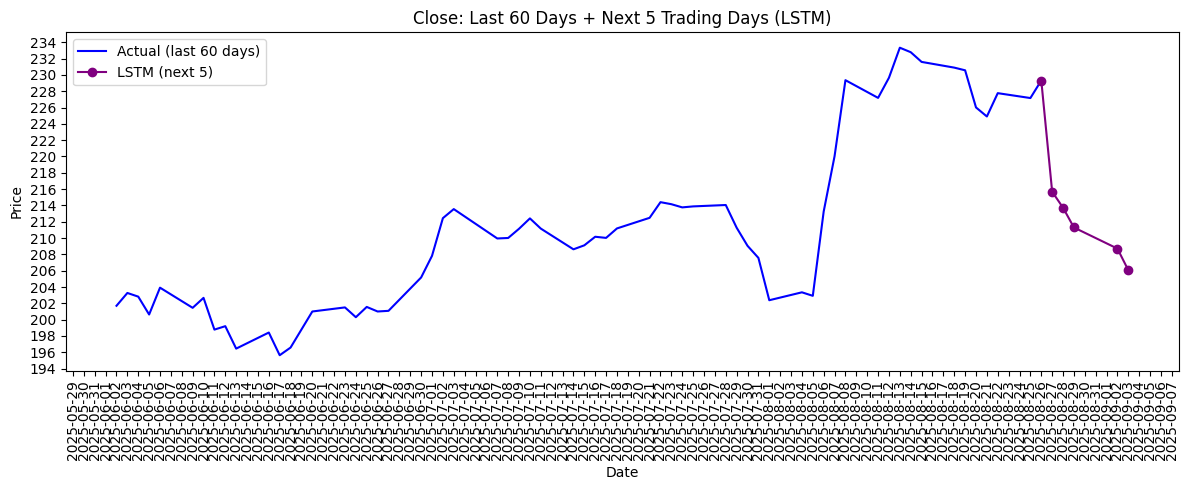

In [22]:
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator

# =========================
# Plot 1: Last 60 actual + next 5 (Linear Regression, connected line, all dates)
# =========================
past_60 = raw['close'].iloc[-60:]
plt.figure(figsize=(12, 5))

# Actual history
plt.plot(past_60.index, past_60.values, label='Actual (last 60 days)', color="blue")

# Forecast connected to last actual close
lin_x = [past_60.index[-1]] + list(future_pred.index)
lin_y = [past_60.values[-1]] + list(future_pred['Linear_Pred_Close'].values)
plt.plot(lin_x, lin_y, marker='o', label='Linear Regression (next 5)', color='purple')

# Show every trading day on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)
ax.yaxis.set_major_locator(MultipleLocator(2))

plt.title('Close: Last 60 Days + Next 5 Trading Days (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# Plot 2: Last 60 actual + next 5 (LSTM, connected line, all dates)
# =========================
plt.figure(figsize=(12, 5))

# Actual history
plt.plot(past_60.index, past_60.values, label='Actual (last 60 days)', color="blue")

# Forecast connected to last actual close
lstm_x = [past_60.index[-1]] + list(future_pred.index)
lstm_y = [past_60.values[-1]] + list(future_pred['LSTM_Pred_Close'].values)
plt.plot(lstm_x, lstm_y, marker='o', label='LSTM (next 5)', color='purple')

# Show every trading day on the x-axis
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)
ax.yaxis.set_major_locator(MultipleLocator(2))

plt.title('Close: Last 60 Days + Next 5 Trading Days (LSTM)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()